In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from pathlib import Path
import pandas as pd

/home/belucci/miniconda3/envs/ml/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Setup GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Memory reserved: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 2070 with Max-Q Design
Memory allocated: 0.00 GB
Memory reserved: 0.00 GB


In [3]:
# Pretrained ResNet50
model = models.resnet50(pretrained=True)
model.fc = torch.nn.Identity()  # remove classification head
model = model.to(device)  # Move model to GPU
model.eval()

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = CIFAR100(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=512, shuffle=False)

/home/belucci/miniconda3/envs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/belucci/miniconda3/envs/ml/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
embeddings, labels = [], []
with torch.no_grad():
    for x, y in tqdm(loader):
        x = x.to(device)  # Move input data to GPU
        z = model(x)  # 2048-d embedding on GPU
        embeddings.append(z.cpu())  # Move back to CPU for storage
        labels.append(y)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Labels shape: {labels.shape}")

100%|██████████| 98/98 [04:19<00:00,  2.64s/it]



Embeddings shape: (50000, 2048)
Labels shape: (50000,)


In [8]:
labels

array([19, 29,  0, ...,  3,  7, 73], shape=(50000,))

In [22]:
data_dir = Path("/home/belucci/code/cohirf/data/cifar-100")
data_dir.mkdir(parents=True, exist_ok=True)

In [7]:
X = pd.DataFrame(embeddings)
y = pd.DataFrame(labels, columns=["label"])
X.to_csv(data_dir / "X.csv")
y.to_csv(data_dir / "y.csv")

In [4]:
# Fine (100-class) label names
fine_labels = dataset.classes  # list of 100 class names
print(len(fine_labels), fine_labels[:10])  # sanity check
# Mapping: fine label index -> class name
fine_label_map = {i: name for i, name in enumerate(fine_labels)}

100 ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']


In [ ]:
# CIFAR-100 superclass structure
superclass_names = [
    "aquatic_mammals",
    "fish", 
    "flowers",
    "food_containers",
    "fruit_and_vegetables",
    "household_electrical_devices",
    "household_furniture",
    "insects",
    "large_carnivores",
    "large_man-made_outdoor_things",
    "large_natural_outdoor_scenes",
    "large_omnivores_and_herbivores",
    "medium_mammals",
    "non-insect_invertebrates",
    "people",
    "reptiles",
    "small_mammals",
    "trees",
    "vehicles_1",
    "vehicles_2"
]

superclass = [
    ["beaver", "dolphin", "otter", "seal", "whale"],
    ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    ["orchid", "poppy", "rose", "sunflower", "tulip"],
    ["bottle", "bowl", "can", "cup", "plate"],
    ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    ["clock", "keyboard", "lamp", "telephone", "television"],
    ["bed", "chair", "couch", "table", "wardrobe"],
    ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    ["bear", "leopard", "lion", "tiger", "wolf"],
    ["bridge", "castle", "house", "road", "skyscraper"],
    ["cloud", "forest", "mountain", "plain", "sea"],
    ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
    ["fox", "porcupine", "possum", "raccoon", "skunk"],
    ["crab", "lobster", "snail", "spider", "worm"],
    ["baby", "boy", "girl", "man", "woman"],
    ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    ["lawn_mower", "rocket", "streetcar", "tank", "tractor"],
]

# Create mapping from fine label to coarse label
fine_to_coarse_map = {}
coarse_label_map = {}

for coarse_idx, fine_classes in enumerate(superclass):
    coarse_label_map[coarse_idx] = superclass_names[coarse_idx]
    for fine_class in fine_classes:
        # Find the fine label index for this class name
        fine_idx = fine_labels.index(fine_class)
        fine_to_coarse_map[fine_idx] = coarse_idx

Number of superclasses: 20
Superclass names: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Fine to coarse mapping created for 100 classes


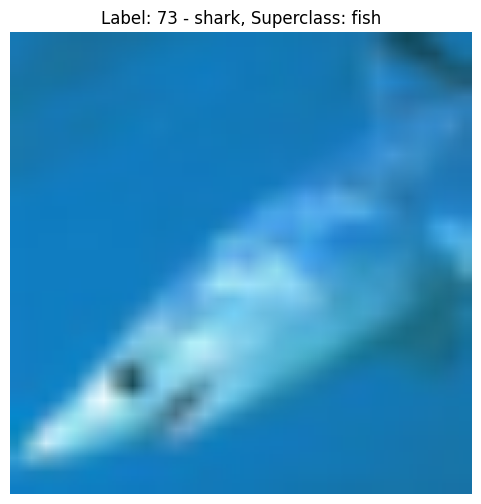

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Get one image and its label from the dataset
img, label = dataset[50]

# Unnormalize the image for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Convert tensor to numpy array and change from C,H,W to H,W,C
img_disp = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C

# Unnormalize
img_disp = std * img_disp + mean
img_disp = np.clip(img_disp, 0, 1)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img_disp)
plt.title(f"Label: {label} - {fine_label_map[label]}, Superclass: {coarse_label_map[fine_to_coarse_map[label]]}")
plt.axis('off')
plt.show()

In [27]:
X = pd.read_csv(data_dir / "X.csv", index_col=0)
y = pd.read_csv(data_dir / "y.csv", index_col=0)

In [28]:
y_coarse = y['label'].map(fine_to_coarse_map)

In [31]:
data_dir = Path("/home/belucci/code/cohirf/data/cifar-100-coarse")
data_dir.mkdir(parents=True, exist_ok=True)

In [32]:
X.to_csv(data_dir / "X.csv")
y_coarse.to_csv(data_dir / "y.csv")

In [33]:
# save maps
import pickle

with open(data_dir / "coarse_to_fine_map.pkl", "wb") as f:
    pickle.dump(fine_label_map, f)
    
with open(data_dir / "fine_to_coarse_map.pkl", "wb") as f:
    pickle.dump(fine_to_coarse_map, f)

with open(data_dir / "coarse_label_map.pkl", "wb") as f:
    pickle.dump(coarse_label_map, f)

In [34]:
len(y)

50000